## Implementing ISODATA.
Fernandez Paz Isaac Santiago.



In [ ]:
import numpy as np 
from numpy import linalg
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
sns.set_theme()

## Implementa el algoritmo (7 puntos)

In [ ]:
class Isodata(): 
  def __init__(self, X, Y): ##Funtion to instance our class with our respective data points and Y centroids given.
    self.X = X.copy() #Copy of our initial data points.
    self.Y = Y.copy() #Copy of the centroids
    self.c = len(self.Y) #number of centroids
    self.m = len(self.X) #number of entries.

  def assign_clusters(self):
    # Calculate the distance between each data point in `self.X` and each cluster center in `self.Y`
    distMat = distance_matrix(self.X, self.Y)
    
    # Find the index of the cluster center with the smallest distance for each data point
    # `np.argmin` is used to find the minimum value in each row of the distance matrix `distMat`
    # `np.array` is used to convert the resulting index values into a numpy array
    self.labels = np.array([np.argmin(distMat[i]) for i in range(len(distMat))])


  def remove_C(self):
      # Check if there are any clusters with fewer than `self.m0` data points
      if any([len(np.where(self.labels==i)[0]) < self.m0 for i in range(self.c)]):
          
          # Remove the first cluster with fewer than `self.m0` data points from `self.Y` using `np.delete`
          # `np.where` is used to find the indices of data points belonging to the cluster
          # `axis=0` is used to specify that the cluster center should be removed from `self.Y`
          self.Y = np.delete(self.Y, [i for i in range(self.c) if len(np.where(self.labels==i)[0]) < self.m0][0], axis=0)
          
          # Update the number of clusters
          self.c = len(self.Y)
          
          # Reassign data points to clusters using `self.assign_clusters`
          self.assign_clusters()


  def splitting_clusters(self):
    # Find the index of the cluster with the largest standard deviation (`sigmajMax`) that exceeds `self.sigma0`
    j = [i for i in range(self.c) if self.sigmajMax[i] > self.sigma0][0] #al menos habrá un elemento porque es condición para que splitting se llame
    
    # Extract the center of the cluster `j` as a numpy array
    yj = self.Y[j, :]
    
    # Find the index of the dimension with the largest standard deviation for cluster `j`
    i0 = self.sigmajMaxI0[j] 
    
    # Create two new cluster centers by adding and subtracting `self.lamb*self.sigmajMax[j]` from the ith dimension of `yj`
    yjMenos = yjMas = yj.copy()
    yjMenos[i0] -= self.lamb*self.sigmajMax[j]
    yjMas[i0] += self.lamb*self.sigmajMax[j]
    
    # Remove cluster `j` from `self.Y`
    self.Y = np.delete(self.Y, j, axis=0)
    
    # Add the two new cluster centers to `self.Y`
    self.Y = np.vstack((self.Y, yjMenos, yjMas))
    
    # Update the number of clusters
    self.c = len(self.Y)
    
    # Reassign data points to clusters using `self.assign_clusters`
    self.assign_clusters()


  def lumping_clusters(self, l3): 
    # Compute the Euclidean distance matrix for the cluster centers and extract the lower triangular matrix
    lowerT = np.tril(squareform(pdist(self.Y, metric='euclidean')), k=-1)
    # Get the indices of the nonzero elements in `lowerT`
    i, j = np.where(lowerT != 0)
    # Sort the indices of the nonzero elements in increasing order of their corresponding distances
    idx = np.argsort(lowerT[(i, j)])
    
    sortedIndices = np.column_stack((i[idx], j[idx]))
    # Create a list to keep track of the clusters that have been lumped together
    lumped = []
     # Loop over the sorted indices of the pairwise distances between cluster centers
    for i in range(len(sortedIndices)):
    # If neither cluster has already been lumped with another cluster
      if sortedIndices[i][0] not in lumped and sortedIndices[i][1] not in lumped:
    # Count the number of points in each cluster
        mi = len(np.where(self.labels == sortedIndices[i][0])[0])
        mj = len(np.where(self.labels == sortedIndices[i][1])[0])
    # Compute the new cluster center as a weighted average of the centers of the two clusters
        Ynuevo = (self.Y[sortedIndices[i][0]]*mi + self.Y[sortedIndices[i][1]]*mj)/(mi + mj)
     # Add the new cluster center to `self.Y`
        self.Y = np.vstack((self.Y, Ynuevo))
    # Add the indices of the two clusters that have been lumped together to `lumped`
        lumped.append(sortedIndices[i][0])
        lumped.append(sortedIndices[i][1])
    
    self.Y = np.delete(self.Y, lumped, axis=0)
    
    self.c = len(self.Y)
    # Reassign data points to clusters using `self.assign_clusters`
    self.assign_clusters()

  def update_centers(self): 
    ##checks if the centroids have converged by comparing the distance between the old and new centroids 
    #(stored in "Z" and "Y", respectively) to a small value "epsilon". 
    #If the distance is smaller than epsilon and the number of clusters h
    #as not changed ("self.c" equals "self.c2"), the variable "NC" is set to 0.
    self.Y = np.array([np.mean(self.X[np.where(self.labels == i)[0], :], axis=0) for i in range(self.c)])
    if self.c == self.c2 and linalg.norm(self.Y-self.Z) < self.epsilon: #idk
      self.NC = 0
    
    self.assign_clusters()

  def compute_avg_distances(self): 
    #Computes the average distance within a certain class "j"
    self.dj = [np.sum(linalg.norm(self.X[np.where(self.labels == i)[0], :] - self.Y[i, :], axis=1))/len(np.where(self.labels == i)[0]) for i in range(self.c)]

  def compute_global_distance(self): 
    ##Compute the average of all distances in all classes.
    self.d = np.sum([self.dj[i]*len(np.where(self.labels == i)[0]) for i in range(self.c)])/self.m

  def compute_std(self): 
    #computes the standard deviation of each cluster and stores the result in a numpy array called "sigmaj". 
    self.sigmaj = np.array([np.sqrt(np.sum((self.X[np.where(self.labels == i)[0], :] - self.Y[i])**2, axis=0)/len(self.X[np.where(self.labels == i)[0], :])) for i in range(self.c)])
    #computes the maximum standard deviation across all clusters and stores the result. 
    #This is done using another list comprehension that iterates over each element of "sigmaj" and takes the maximum value.
    self.sigmajMax = np.array([np.max(i) for i in self.sigmaj])
    #computes the index of the feature with the maximum standard deviation for each cluster and stores the result 
    self.sigmajMaxI0 = np.array([np.argmax(i) for i in self.sigmaj])
  
  def classifier(self, N, k, m0, epsilon, sigma0, lamb, d0, l): 
    
    #N: max number of iterations
    #k: desired clusters
    #m0: parameter for the minumum elements in a cluster.
    #epsilon: error tolerance.
    #sigma0: standard deviation parameter.
    #lamb: plitting factor
    #d0: lumping threshold
    #l: max number of groups that can be lumped together
    
    self.N = N 
    self.k = k 
    self.m0 = m0
    self.epsilon = epsilon 
    self.sigma0 = sigma0 
    self.lamb = lamb 
    self.d0 = d0
    self.l = l
    self.labels = np.array([]) 

    #Step 1:
    self.S = np.array([2]*self.N)
    self.L = np.array([2]*self.N) 
    for it in range(self.N):
      self.iter = it+1
      #Step 2:
      self.c2 = self.c
      self.Z = self.Y.copy()
      self.NC = 1
      self.assign_clusters()
      #Step 3:
      self.remove_C()
      #Step 4:
      self.update_centers()
      #Step 5:
      self.compute_avg_distances()
      #Step 6:
      self.compute_global_distance()

      #Step 7 a)
      if self.c <= (self.k + 1)/2:
        #Step 8:
        self.S[it] = 0
        self.flag = 3
        self.compute_std()
        #Checking againts standard deviation parameter.
        if any([self.sigmajMax[i] > self.sigma0 for i in range(self.c)]):
          #Generating two clusters from one.
          self.splitting_clusters()
          self.S[it] = 1
        else:
          if it>1 and self.L[it-1]==0 and self.NC==0:
            break 
          elif it>1 and self.L[it-1]==0 and self.NC==1:
            continue 
          elif it>1 and self.L[it-1]!=0:
            continue
          elif it==1:
            continue 

      #Step 7 c)
      elif self.c >= 2*self.k:
        #Step 10:
        self.L[it] = 0
        if self.c < 2 and self.S[it] == 0 and self.NC == 0:
          break
        elif (self.c < 2 and self.S[it] == 0 and self.NC == 1) or (self.c < 2 and self.S[it] == 2):
          continue
        else:
          #Checking for distances in each data point, and sorting them.
          dij = np.sort(pdist(self.Y, metric='euclidean'))
          l2 = len([i for i in dij if i <= self.d0])
          l3 = min(self.l, l2)
          if l3==0:
            if self.S[it]==2:
             continue
            elif self.S[it]==0:
              break
          else:
            self.L[it] = 1
            self.lumping_clusters(l3) 

      #Step 7 b)
      else:
        if it%2:
          #Step 8:
          self.S[it] = 0
          self.flag = 3
          self.compute_std()
          #Comparing against our standard devaition parameter.
          try:
            j = [i for i in range(self.c) if self.sigmajMax[i] > self.sigma0][0]
          except:
            continue 
          if any([self.sigmajMax[i] > self.sigma0 for i in range(self.c)]) and (self.dj[j] > self.d or len(np.where(self.labels == j)[0]) >= 2*self.m0):
            #Again, break on cluster into two.
            self.splitting_clusters()
            self.S[it] = 1
          else:
            if it>1 and self.L[it-1]==0 and self.NC==0:
              break 
            elif it>1 and self.L[it-1]==0 and self.NC==1:
              continue 
            elif it>1 and self.L[it-1]!=0:
              continue
            elif it==1:
              continue

        #Step 7 d)
        else:
          #Step 10:
          self.L[it] = 0
          if self.c < 2 and self.S[it] == 0 and self.NC == 0:
            break
          elif (self.c < 2 and self.S[it] == 0 and self.NC == 1) or (self.c < 2 and self.S[it] == 2):
            continue
          else:
            dij = np.sort(pdist(self.Y, metric='euclidean'))
            l2 = len([i for i in dij if i <= self.d0])
            l3 = min(self.l, l2)
            if l3==0:
              if self.S[it]==2:
                continue
              elif self.S[it]==0:
                break
            else:
              self.L[it] = 1
              self.lumping_clusters(l3) 

    
    return self.Y, self.labels, self.iter #Return labels, centroids and iterations.

## Test del algoritmo (1 punto)

Prueba el algoritmo con los siguientes patrones y grafica el resultado. 

In [ ]:
X = np.array([[0, 0], [1, 0], [1, 1], [0, 1], [4, 1], [5, 1], [5, 2], [7, 1], [7, 2], [6, 3], [2 ,3], [1, 4], [2, 5], [3, 5]], dtype=float)
y = np.array([[0, 0], [4, 1], [7, 2], [2, 3], [3, 5]], dtype=float)

In [ ]:
iso = Isodata(X, y)
centroids, labels, iterations = iso.classifier(30, 5, 2, 0.5, 1, 1, 2, 2)

Text(0, 0.5, 'Y')

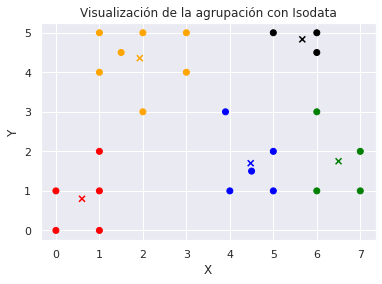

In [ ]:
c = {0: 'red', 1:'blue', 2:'green',3:'orange',4:'black',5:'yellow'}
cX = [c[i] for i in labels]
cC = [c[i] for i in range(len(centroids))]

plt.scatter(X[:, 0], X[:, 1], c=cX)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', c=cC)
plt.title('Visualización de la agrupación con Isodata')
plt.xlabel('X')
plt.ylabel('Y')

## Mini-Cuestionario (2 puntos)

### Opinión: 

### Conteste las 4 preguntas típicas de análisis y diseño de algoritmos


**1. ¿Es correcto?**

La clasificación que realizo este metodo con los parametros dados, parece que obtuve resultados "favorables". Sin embargo, la diferencia entre grupos no es tan dicernible al momento de tomar en cuenta cinco grupos. En especial para los grupos verde y azul, estan a una distancia muy cercana el uno del otro, tambien es importante considerar que la extensión de neustros datos es reducida. 

El algoritmo es correcto pues los datos de salida son los esperados, se obtuvieron 5 grupos que cumplen con los parametros establecidos para nuestra clase ISODATA.


**2. ¿Complejidad temporal?**

La complejidad temporal de ISODATA depende de varios factores, como el tamaño del conjunto de datos, el número de clústeres y los valores de umbral utilizados para fusionar y dividir los clústeres. En general, la complejidad temporal de ISODATA puede considerarse como $O(N \cdot K \cdot I)$, donde N es el número de puntos de datos, K es el número de clústeres e I es el número de iteraciones.

La complejidad temporal de ISODATA se puede reducir estableciendo valores apropiados para los parámetros, como el número mínimo y máximo de clústeres, el tamaño mínimo y máximo del clúster y el umbral de convergencia. Además, ISODATA se puede optimizar mediante la paralelización del cálculo de las métricas de distancia entre los puntos de datos y los centroides de los clústeres.




**3. ¿Complejidad espacial?**
En general, la complejidad de espacio de ISODATA puede considerarse como $O(N + K)$, donde N es el número de puntos de datos y K es el número de clústeres.

La complejidad de espacio de ISODATA se debe al almacenamiento de los datos y de los parámetros necesarios para el algoritmo, como los centroides de los clústeres, los umbrales de convergencia, el número de iteraciones, etc.

**4. ¿Ventajas y desventajas?**

Ventajas:

* ISODATA es un algoritmo rápido y eficiente que puede procesar grandes  conjuntos de datos.
* Es capaz de adaptarse a diferentes estructuras de datos y patrones de agrupamiento, lo que lo hace útil para una variedad de aplicaciones.
* ISODATA utiliza una estrategia iterativa para optimizar los clústeres, lo que mejora la precisión y la calidad de los resultados.
* Permite la especificación de varios parámetros para controlar el proceso de agrupamiento, lo que proporciona una mayor flexibilidad para adaptarse a diferentes necesidades.

Desventajas:

* La calidad de los resultados de ISODATA puede verse afectada por la elección incorrecta de los parámetros, lo que puede generar resultados inexactos o no deseados.
* ISODATA no es adecuado para todos los tipos de datos, como los datos con una alta densidad de ruido o los datos con una alta dimensión.
* El algoritmo requiere de una cantidad significativa de memoria y potencia de cómputo para procesar grandes conjuntos de datos.
* Puede ser difícil determinar el número óptimo de clústeres para un conjunto de datos dado.






